## Time Series Forecasting using XGBoost Regressor 

XGBoost Regressor is an implementation of gradient-boosted decision trees specifically designed for regression tasks. XGBoost, which stands for Extreme Gradient Boosting, is known for its high performance, speed, and ability to handle complex datasets with high accuracy.

Gradient Boosting:

XGBoost uses gradient boosting, where each new tree is fitted to the gradient of the error, optimizing the loss function and thus creating a model that focuses on the parts of data that previous models mispredicted.

Regularization:

XGBoost Regressor has built-in regularization parameters (alpha for L1 regularization and lambda for L2 regularization) to control overfitting, making it robust for large and complex datasets.

Parallelization and Optimization:

XGBoost is highly optimized for both memory usage and speed. It supports parallel processing and can efficiently handle large datasets. This makes it faster than traditional implementations of gradient boosting.

XGBoost Regressor is popular for both structured/tabular data and time-series forecasting due to its performance and accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/kaggle/input/house-energy-consumption-usa/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head(10)  #here Datetime is our index

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


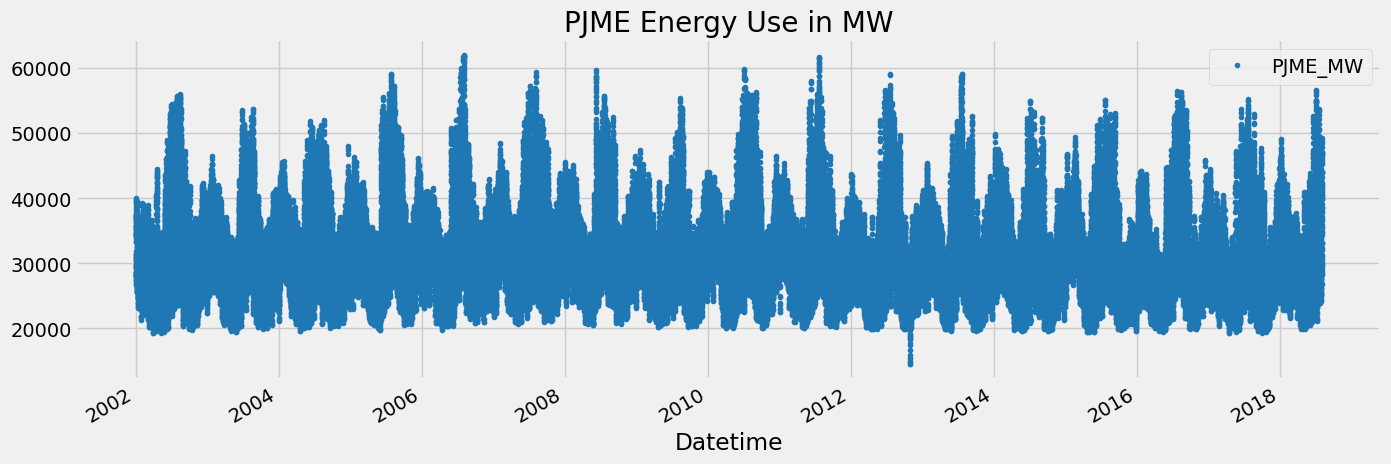

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

### Train/Test Split

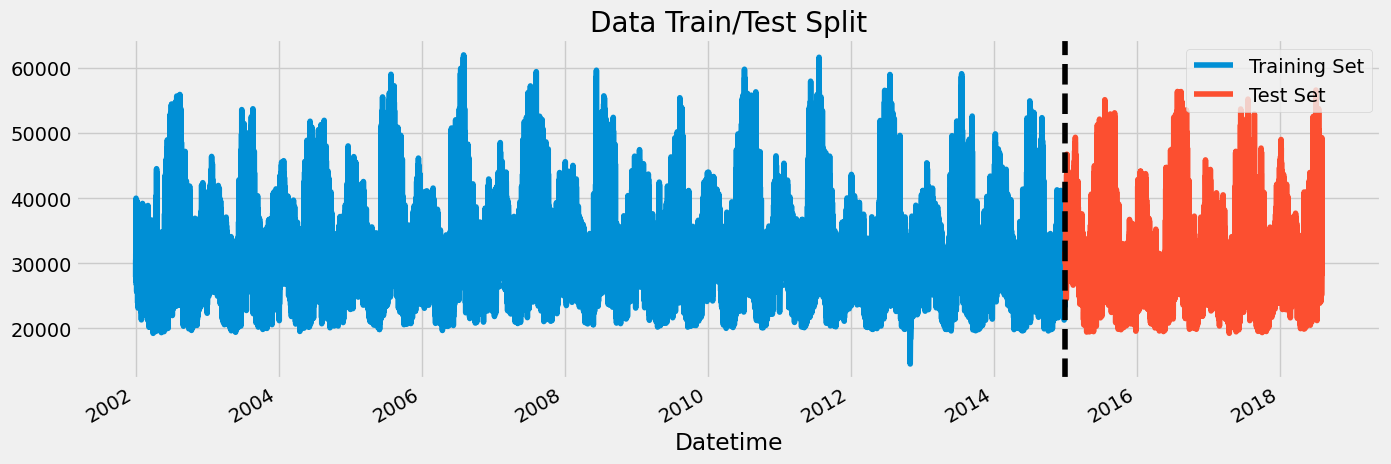

In [5]:
#separating the train and test data manually 
train = df.loc[df.index < '01-01-2015']  
test = df.loc[df.index >= '01-01-2015']


#visz. of both train and test
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

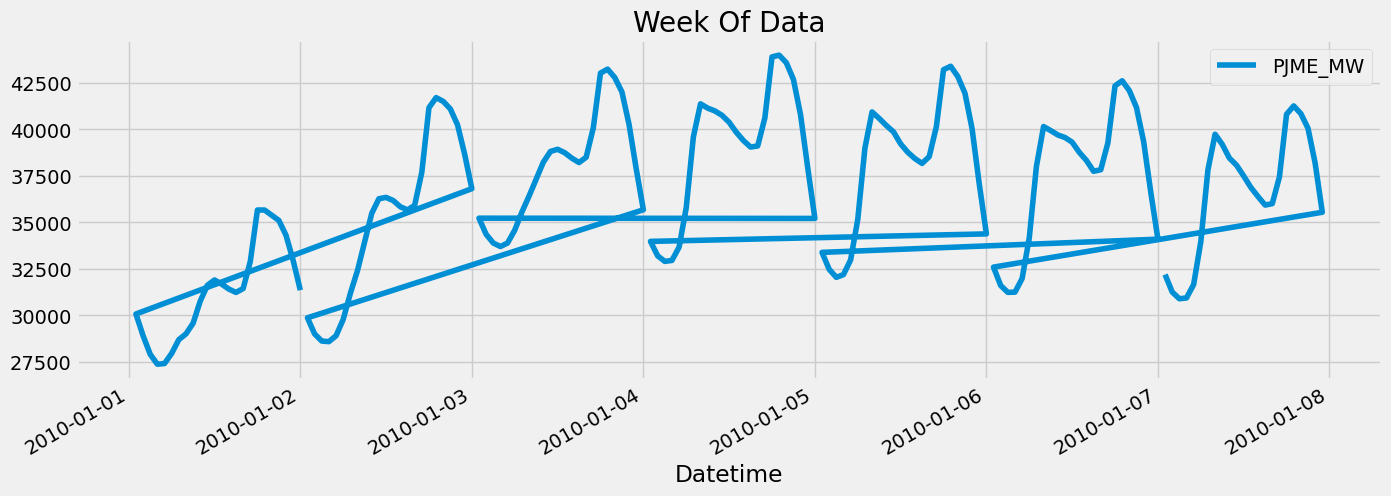

In [6]:
#visz. of one week energy 
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Features creation

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df1 = df.copy()
    df1['hour'] = df1.index.hour
    df1['dayofweek'] = df1.index.dayofweek
    df1['quarter'] = df1.index.quarter
    df1['month'] = df1.index.month
    df1['year'] = df1.index.year
    df1['dayofyear'] = df1.index.dayofyear
    df1['dayofmonth'] = df1.index.day
    df1['weekofyear'] = df1.index.isocalendar().week
    return df1

df = create_features(df)

In [8]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


## Visualization of Feature/Target Relationship

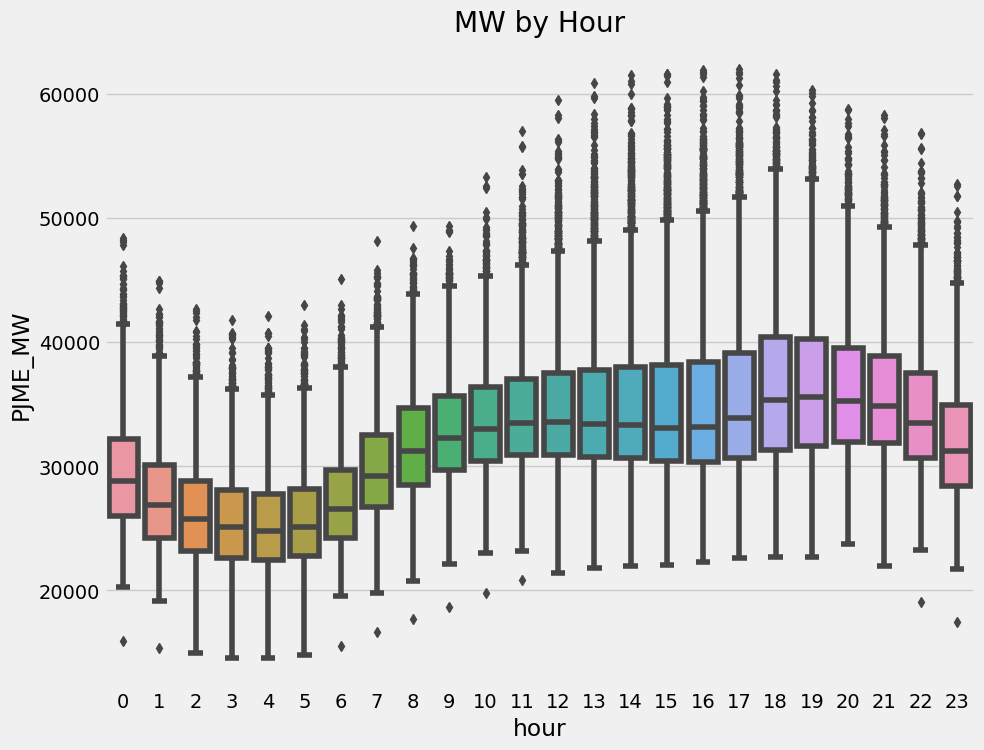

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

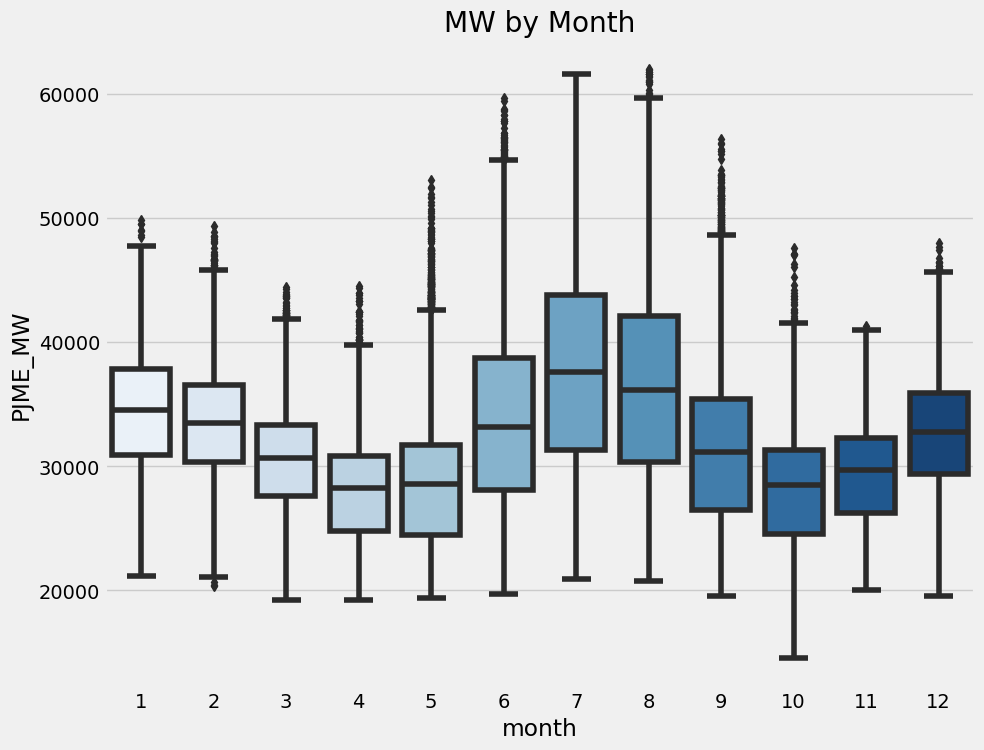

In [10]:
##for each month 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Creating our Model XGBOOSTREG

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter distribution for random search
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000],  # Start with fewer options
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}

# Set up the model without specific parameters
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',objective='reg:squarederror', early_stopping_rounds=50)

# Set up RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=100,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV
randomized_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)



Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0
[0]	validation_0-rmse:30353.14556
[CV 2/3; 1/50] START colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0
[0]	validation_0-rmse:30364.46191
[CV 3/3; 1/50] START colsample_bytree=1.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000, reg_alpha=0, reg_lambda=1, subsample=1.0
[0]	validation_0-rmse:30341.49561
[CV 1/3; 2/50] START colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=1000, reg_alpha=0.01, reg_lambda=1.5, subsample=0.8
[0]	validation_0-rmse:31653.93732
[100]	validation_0-rmse:3758.87156
[100]	validation_0-rmse:3742.25338
[100]	validation_0-rmse:4127.41564
[100]	validation_0-rmse:11528.08983
[108]	validation_0-rmse:4191.282

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=50,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3],
                                        'n_estimators': [100, 500, 1000],
                                        'reg_alpha': [0, 0.01],
                                        'reg_lambda': [1, 1.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=100)

Parameter Grid: You can adjust the ranges in param_grid to include more or fewer options depending on how thorough you want the search to be.

Cross-Validation (cv=3): This performs a 3-fold cross-validation for each combination.

Model Fitting: GridSearchCV will train on each parameter combination, evaluate using cross-validation, and output the best combination.

In [13]:
# Output the best parameters and score
print("Best parameters found: ", randomized_search.best_params_)
print("Best RMSE score: ", -randomized_search.best_score_)


best_model = randomized_search.best_estimator_  #this will be the best model fitted we will use 
print("Best model is :" ,best_model)

Best parameters found:  {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best RMSE score:  10957024.433142146
Best model is : XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


## Feature importance

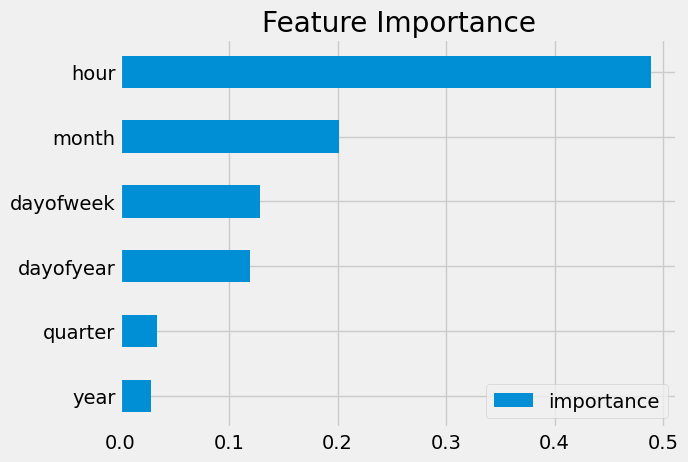

In [14]:
fi = pd.DataFrame(data=best_model.feature_importances_,
             index=best_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecasting on Test

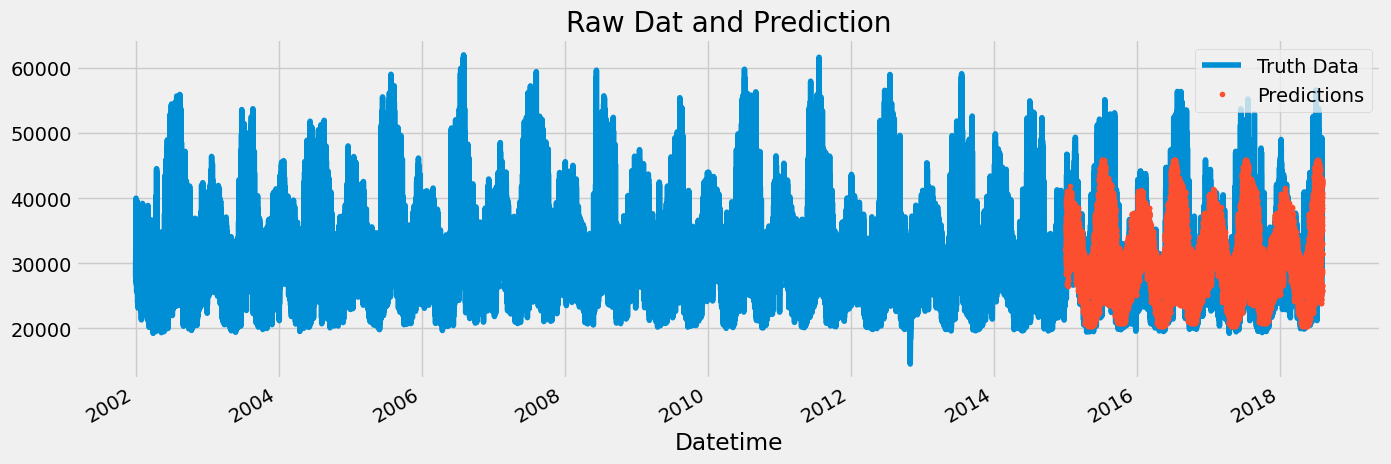

In [15]:
#prediction on our best fit-model

test['prediction']= best_model.predict(X_test)

#merge now with main dataset and visz.
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

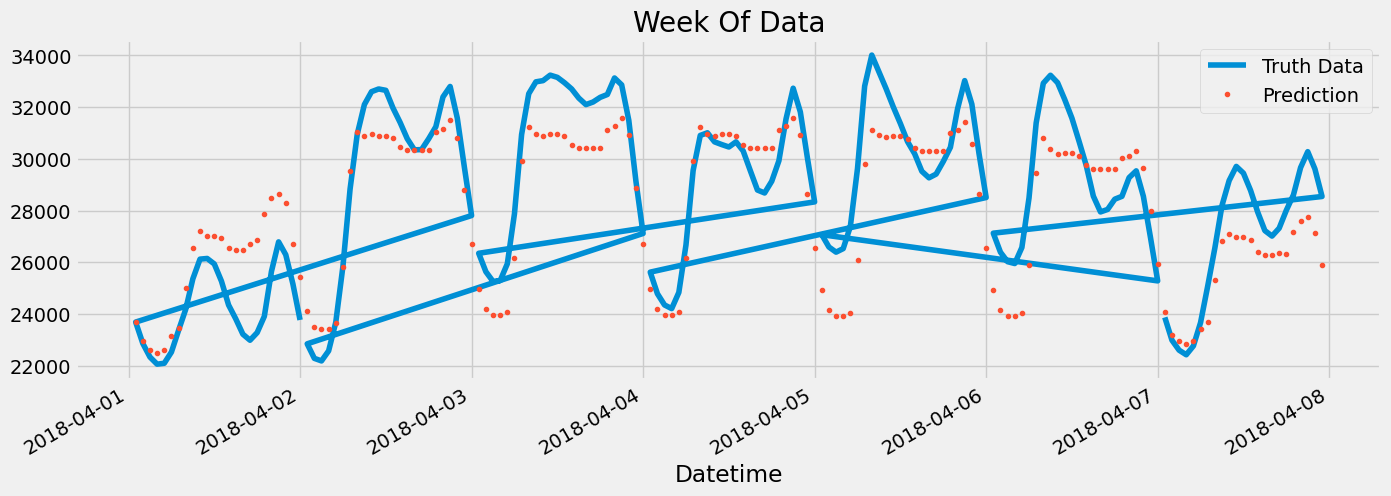

In [16]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## RMSE SCORE 

In [17]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))  #Root of MSE is RMSE
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3766.89


### Lower the value of RMSE better it will be i.e. prediction has been made proper

## Calculate ERROR

In [18]:
##Look at the worst and best predicted days

test['error'] = np.abs(test[TARGET] - test['prediction'])  #this differnce has to be lower for good prediction
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)  #the worst predicted days (Error higher)


date
2016-08-13    15045.926514
2016-08-14    14917.727132
2016-09-10    12154.806315
2016-08-12    11889.368815
2016-09-09    11804.442464
2015-02-20    11054.932210
2018-01-06    10610.862305
2017-05-19    10423.822510
2016-08-11    10339.973226
2018-01-07    10310.564697
Name: error, dtype: float64

In [19]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10) #Best predicted days (Error has to be lower)

date
2016-09-27    312.510173
2015-09-21    340.016357
2016-04-04    359.601562
2016-04-29    365.767497
2018-05-13    373.093669
2016-12-08    376.169922
2018-05-17    391.444255
2018-05-06    423.617513
2016-10-03    426.939941
2016-05-06    428.847412
Name: error, dtype: float64

### If we see here the Error is lower means prediction has been made accurately .

### How we can improve our model to give better predictions/forecast ?

1)Fine-tuning the hyperparameters

Further Tuning: If you suspect that there is still room for improvement,<br> 
consider:
Expanding the hyperparameter grid to explore a broader range of values.<br>
Using techniques like RandomizedSearchCV to sample more combinations quickly.
Implementing techniques such as Bayesian Optimization for hyperparameter tuning

2)Feature Engineering:
    If certain features are very important, consider engineering new features which we can add more like (weather forecast,holidays) 
    or removing unimportant ones.
3) Minimizing RMSE(Root Mean Squared Error) . 

    